# Quantum Embedding of Ising configurations

## Imports and random seed

In [2]:
import os
import random
import numpy as np
import glob
from qiskit import QuantumCircuit, Aer, IBMQ, transpile, QuantumRegister, ClassicalRegister
from qiskit.tools.jupyter import *
from qiskit.utils import QuantumInstance
from qiskit.result.counts import Counts
from qiskit.visualization import plot_histogram
from math import ceil, log2
from typing import Dict, List

from src.utils.train_test_split import train_test_split

In [3]:
def set_random_seed(
    seed: int = 42
) -> None:

    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)

set_random_seed(seed=6)

## Importing the data

In [3]:
# Size of the images, the number of qubits is 2 * ceil(log2(size_image)) + 1   (Height, Width and spin channel)
image_size = 4
# Ising infinite lattice size critical temperature
statistical_control_parameter = 2.2692 

with open('./data/ising/L={}/T={:.4f}.bin'.format(image_size, statistical_control_parameter), 'rb') as f:
    X = np.frombuffer(buffer=f.read(), dtype=np.int8, offset=0).reshape(-1, image_size, image_size)

idx = np.random.randint(X.shape[0])
image = X[idx]

In [4]:
image_size = 4
dataset_size = 4

images = []
labels = []

for file_path in glob.glob('./data/ising/L={}/*'.format(image_size)):
    with open(file_path, 'rb') as f:
        X = np.frombuffer(buffer=f.read(), dtype=np.int8, offset=0).reshape(-1, image_size, image_size)
        temperature = float(file_path.split('=')[-1].split('.bin')[0])
        y = np.full(shape=(X.shape[0],), fill_value=temperature)

        images.append(X)
        labels.append(y)

X = np.concatenate(images, axis=0)        
y = np.concatenate(labels, axis=0)   

# Permuting the dataset
idx = np.random.permutation(X.shape[0])
X = X[idx][:dataset_size]
y = y[idx][:dataset_size]

# Splitting train set into train and validation set
X_train, y_train, X_test, y_test = train_test_split(X, y, validation_fraction=0.2)

In [5]:
X1 = X[:2] 
X2 = X[2:]

In [56]:
image = X[3]

In [57]:
image

array([[ 1, -1,  1,  1],
       [ 1, -1,  1,  1],
       [ 1,  1, -1,  1],
       [ 1,  1,  1,  1]], dtype=int8)

## NEQR Quantum encoding

In [58]:
def binary_formatting(
    digit: int,
    n_bits: int,
    reverse: bool = False,
) -> str:
    r"""
    Args:
        digit (int): number whose binary representation we are computing
        n_bits (int): number of bits used in the binary representation (to handle left trailing zeros)
        reverse (bool): optionally return the binary representation of digit in reverse order (for qiskit convention)
    Returns:
        (str): binary representation of digit
    """

    binary = format(digit, '0{}b'.format(n_bits))

    if reverse:
        binary = binary[::-1]

    return binary

In [59]:
side_qubits = ceil(log2(image_size))
image_qubits = 2 * side_qubits
total_qubits = image_qubits + 1

We will assign |0> to a -1 spin and |1> to a +1 spin.

In [60]:
def image_to_circuit(
    image: np.ndarray,
    measure: bool = False,
    use_ancilla: bool = False
) -> QuantumCircuit:

    image_size = image.shape[0]
    side_qubits = ceil(log2(image_size))
    image_qubits = 2 * side_qubits
    total_qubits = image_qubits + 1

    image_register = QuantumRegister(image_qubits, 'position')
    spin_register = QuantumRegister(1,'spin')

    #if measure:
    #    classical_register = ClassicalRegister(image_qubits + 1, 'classical register')
    #    qc = QuantumCircuit(spin_register, image_register, classical_register)

    #else:

    if use_ancilla:
        ancilla_register = QuantumRegister(1, 'ancilla')
        #classical_register = ClassicalRegister(image_qubits + 2, 'classical register')
        #qc = QuantumCircuit(spin_register, image_register, ancilla_register, classical_register)
        qc = QuantumCircuit(spin_register, image_register, ancilla_registertop)
    else:
        qc = QuantumCircuit(spin_register, image_register)

    qc.i(0)
    for i in range(1, image_register.size + 1):
        qc.h(i)
    if use_ancilla:
        qc.i(image_register.size+1)

    qc.barrier()

    for i in range(image_size):
        for j in range(image_size):

            if image[i, j] == 1:

                binarized_i = binary_formatting(digit=i, n_bits=side_qubits, reverse=False)
                binarized_j = binary_formatting(digit=j, n_bits=side_qubits, reverse=False)

                flip_idx = []

                for ii in range(side_qubits):
                    if binarized_i[ii] == '1':
                        flip_idx.append(ii+1)
                        qc.x(ii+1)

                for jj in range(side_qubits):
                    if binarized_j[jj] == '1':
                        flip_idx.append(jj+side_qubits+1)
                        qc.x(jj+side_qubits+1)

                if use_ancilla:
                    qc.mcx(
                        control_qubits=list(range(1, image_qubits+1)),
                        target_qubit=0,
                        ancilla_qubits=image_qubits+1,
                        mode='recursion'
                    )

                else:
                    qc.mcx(list(range(1, image_qubits+1)), 0, mode='noancilla')

                for q in flip_idx:
                    qc.x(q)

                qc.barrier() 

    if measure:
        qc.measure(range(total_qubits+1), range(total_qubits+1))

    return qc

In [61]:
qc = image_to_circuit(image=image, measure=False, use_ancilla=False)
print('Circuit depth: ', qc.decompose().depth())
print('Circuit size: ', qc.decompose().size())
qc.decompose().count_ops()

Circuit depth:  104
Circuit size:  176


OrderedDict([('u3', 54),
             ('h', 52),
             ('cu1', 26),
             ('barrier', 14),
             ('rcccx', 13),
             ('rcccx_dg', 13),
             ('c3sx', 13),
             ('u2', 4),
             ('id', 1)])

In [62]:
qc_ancilla = image_to_circuit(image=image, measure=True, use_ancilla=True)
print('Circuit depth: ', qc_ancilla.decompose().depth())
print('Circuit size: ', qc_ancilla.decompose().size())
qc_ancilla.decompose().count_ops()

Circuit depth:  39
Circuit size:  79


OrderedDict([('u3', 54),
             ('barrier', 14),
             ('mcx', 13),
             ('measure', 6),
             ('u2', 4),
             ('id', 2)])

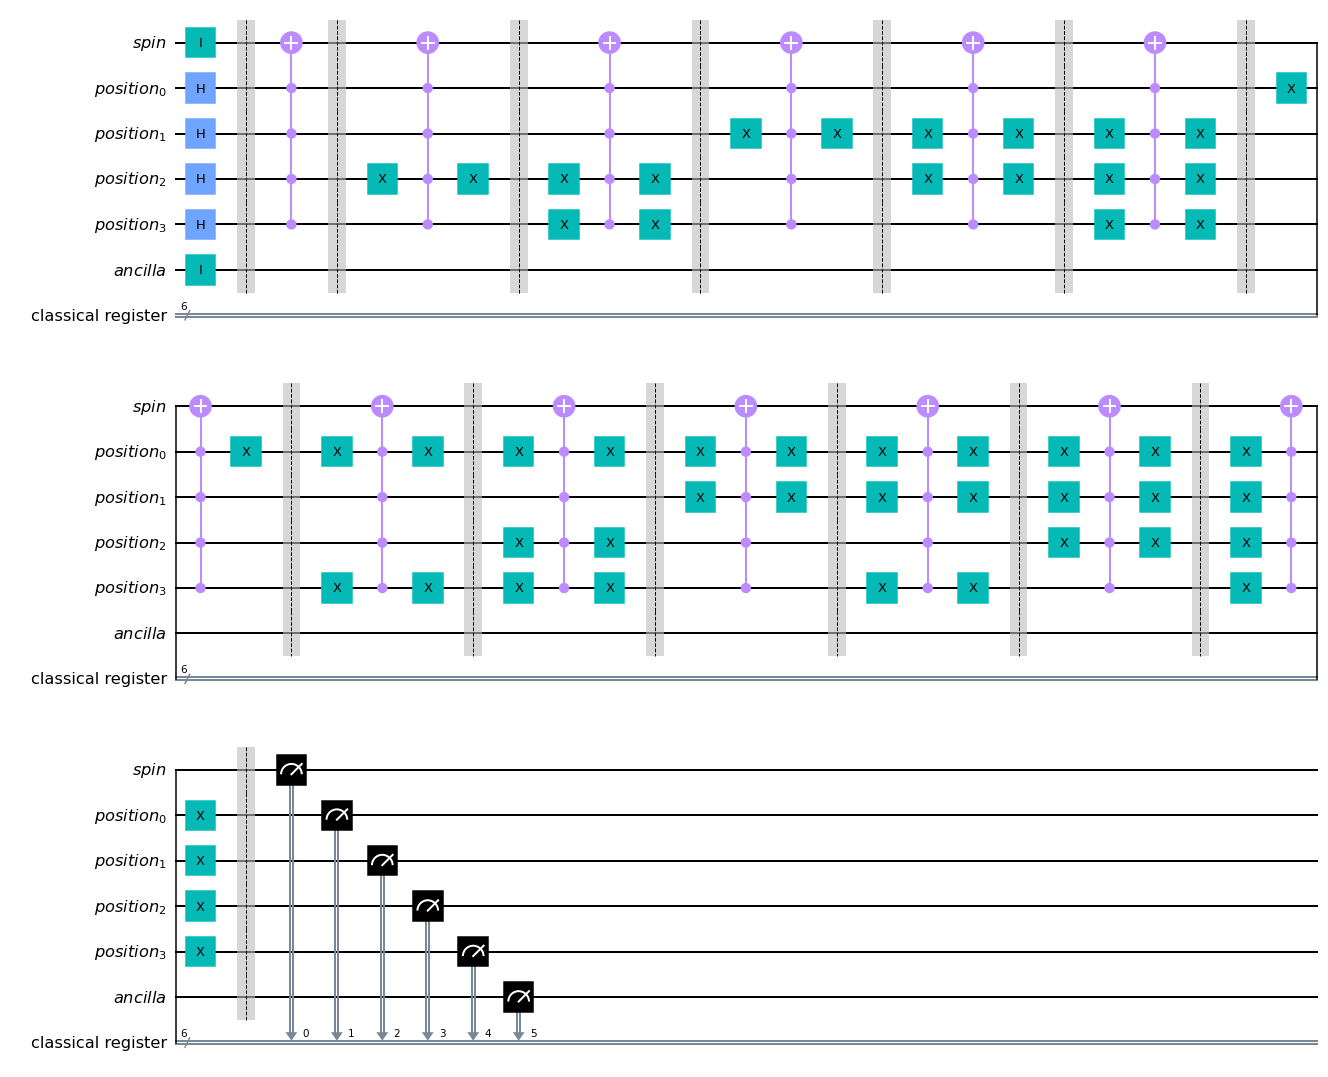

In [63]:
qc_ancilla.draw(output='mpl')

In [12]:
qc.draw(output='mpl').savefig('assets/circuit.png')

In [66]:
backend = Aer.get_backend('qasm_simulator')
result = backend.run(transpile(qc_ancilla, backend)).result()
print(result)
counts = result.get_counts(qc_ancilla)
counts = {key[1:]: value for (key, value) in counts.items()}
counts

Result(backend_name='qasm_simulator', backend_version='0.10.4', qobj_id='56f22646-b8f0-4fd2-b87f-174b25e9c815', job_id='b8dae362-0873-4b87-8b0b-7bf9a668a565', success=True, results=[ExperimentResult(shots=1024, success=True, meas_level=2, data=ExperimentResultData(counts={'0x1f': 69, '0x14': 54, '0xa': 66, '0xe': 65, '0x11': 51, '0x17': 70, '0x9': 62, '0x19': 81, '0x1': 63, '0x5': 73, '0x13': 59, '0x1b': 56, '0xd': 65, '0x1d': 58, '0x3': 63, '0x7': 69}), header=QobjExperimentHeader(clbit_labels=[['classical register', 0], ['classical register', 1], ['classical register', 2], ['classical register', 3], ['classical register', 4], ['classical register', 5]], creg_sizes=[['classical register', 6]], global_phase=0.0, memory_slots=6, metadata={}, n_qubits=6, name='circuit-11003', qreg_sizes=[['spin', 1], ['position', 4], ['ancilla', 1]], qubit_labels=[['spin', 0], ['position', 0], ['position', 1], ['position', 2], ['position', 3], ['ancilla', 0]]), status=DONE, seed_simulator=1537088550, met

{'11111': 69,
 '10100': 54,
 '01010': 66,
 '01110': 65,
 '10001': 51,
 '10111': 70,
 '01001': 62,
 '11001': 81,
 '00001': 63,
 '00101': 73,
 '10011': 59,
 '11011': 56,
 '01101': 65,
 '11101': 58,
 '00011': 63,
 '00111': 69}

In [18]:
backend = Aer.get_backend('qasm_simulator')
result = backend.run(transpile(qc, backend)).result()
counts = result.get_statevector(qc)
counts

QiskitError: 'No statevector for experiment "<qiskit.circuit.quantumcircuit.QuantumCircuit object at 0x7f90d33313a0>"'

In [24]:
np.array([0.0, 0.25, 0.0, 0.25, 0.25, 0.0, 0.25, 0.0, 0.25, 0.0, 0.0,0.25, 0.25, 0.0, 0.0, 0.25, 0.25, 0.0, 0.0, 0.25, 0.25, 0.0,0.25, 0.0, 0.0, 0.25, 0.25, 0.0, 0.0, 0.25, 0.0, 0.25], dtype=np.float64)

array([0.  , 0.25, 0.  , 0.25, 0.25, 0.  , 0.25, 0.  , 0.25, 0.  , 0.  ,
       0.25, 0.25, 0.  , 0.  , 0.25, 0.25, 0.  , 0.  , 0.25, 0.25, 0.  ,
       0.25, 0.  , 0.  , 0.25, 0.25, 0.  , 0.  , 0.25, 0.  , 0.25])

In [11]:
def counts_to_statevector(
    counts: Dict[str, int],
    num_qubits: int,
) -> np.ndarray:
    
    statevector = np.zeros(shape=(2**num_qubits,))
    for key, value in counts.items():
        statevector[int(key, 2)] = value
    statevector = statevector / np.linalg.norm(statevector)
    return statevector

def statevector_to_densitymatrix(
    statevector: np.ndarray
) -> np.ndarray:
    r"""
    Args:
        statevector (np.ndarray): statevector corresponding to a pure state
    Return:
        (np.ndarray): density matrix corresponding to the pure state statevector
    """

    density_matrix = np.outer(statevector, statevector)
    return density_matrix

def images_to_quantumstate(
    image_batch: np.ndarray,
    from_counts: bool = False,
    to_real: bool = False,
    output_densitymatrices: bool = False
) -> List[np.ndarray]:
    r"""
    Args:
        image_batch (np.ndarray): batch of images whose quantum representation we are computing
        from_counts (np.ndarray): whether or not to reconstruct the output statevector statistically from counts or not
        to_real (bool): whether or not to cast the complex components of statevector to real ones
        output_densitymatrices (bool): whether to output the density matrices of the statevectors
    Return:
        (List[np.ndarray]): batch of density matrix representation of the images
    """

    backend = Aer.get_backend('statevector_simulator')
    bounds = []
    num_qubits = 2 * ceil(log2(image_batch.shape[-1])) + 1

    for i in range(image_batch.shape[0]):
        q = image_to_circuit(image=image_batch[i], measure=True if from_counts else False)
        bounds.append(q)
        
    qc = transpile(bounds, backend)

    if from_counts:
        qi = QuantumInstance(backend, seed_transpiler=42, seed_simulator=42, shots=2048)
        result = qi.execute(circuits=qc, had_transpiled=True)
        counts = result.get_counts()

        # Handle the case of a batch containing a single image
        if type(counts) == Counts:
            counts = [counts]

        if to_real:
            import warnings
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                statevector = [counts_to_statevector(counts[ind], num_qubits).astype('float32') for ind in range(len(counts))]
        else:
            statevector = [counts_to_statevector(counts[ind], num_qubits) for ind in range(len(counts))]

    else:
        qi = QuantumInstance(backend, seed_transpiler=42, seed_simulator=42)
        result = qi.execute(circuits=qc, had_transpiled=True)

        if to_real:
            import warnings
            with warnings.catch_warnings():
                warnings.simplefilter("ignore")
                statevector = [result.get_statevector(i).astype('float32') for ind in range(len(bounds))]
        else:
            statevector = [result.get_statevector(i) for i in range(len(bounds))]

    statevector = np.stack(statevector)

    if output_densitymatrices:
        densitymatrices = np.einsum('ab,ac->abc', statevector, statevector)
        return densitymatrices

    else:
        return statevector

In [10]:
batch_size = 200

idx = 1
for i in range(0, X_train.shape[0], batch_size):
    statevector_train = images_to_quantumstate(image_batch=X_train[i: i+batch_size], from_counts=False, to_real=True, output_densitymatrices=False)
    with open('./data/ising/preprocessed/statevector_L=16_train_{}.npy'.format(idx), 'wb') as f:
        np.save(f, statevector_train)
    idx += 1

idx = 1
for i in range(0, X_test.shape[0], batch_size):
    statevector_test = images_to_quantumstate(image_batch=X_test[i: i+batch_size], from_counts=False, to_real=True, output_densitymatrices=False)
    with open('./data/ising/preprocessed/statevector_L=16_test_{}.npy'.format(idx), 'wb') as f:
        np.save(f, statevector_test)
    idx += 1

with open('./data/ising/preprocessed/label_L=16_train.npy', 'wb') as f:
    np.save(f, y_train)
with open('./data/ising/preprocessed/label_L=16_test.npy', 'wb') as f:
    np.save(f, y_test)

In [14]:
def quantum_kernel_estimation(
    X1: np.ndarray,
    X2: np.ndarray,
    from_counts: bool = False,
) -> np.ndarray:
    r"""Return the quantum Gram matrix  
    """

    backend = Aer.get_backend('statevector_simulator')
    num_qubits = 2 * ceil(log2(X1.shape[-1])) + 1

    bounds1 = []
    for i in range(X1.shape[0]):
        q = image_to_circuit(image=X1[i], measure=False)
        bounds1.append(q)

    bounds2 = []
    for i in range(X2.shape[0]):
        q = image_to_circuit(image=X2[i], measure=False)
        bounds2.append(q)

    circuits = []
    for c1 in bounds1:
        for c2 in bounds2:
            c = c2.compose(c1.inverse())
            if from_counts:
                c = c.measure_all(inplace=False)
            circuits.append(c)

    qc = transpile(circuits, backend)

    if from_counts:
        shots = 1024
        qi = QuantumInstance(backend, seed_transpiler=42, seed_simulator=42, shots=shots)
        result = qi.execute(circuits=qc, had_transpiled=True)
        counts = result.get_counts()
        # Handle the case of a batch containing a single image
        if type(counts) == Counts:
            counts = [counts]

        gram = [count[num_qubits*'0'] / shots for count in counts] 
        gram = np.array(gram)

    else:
        computational_basis_vector = np.zeros(shape=(2**num_qubits,))
        computational_basis_vector[0] = 1
        qi = QuantumInstance(backend, seed_transpiler=42, seed_simulator=42)
        result = qi.execute(circuits=qc, had_transpiled=True)
        statevector = [np.real(result.get_statevector(i)) for i in range(len(circuits))]
        statevector = np.stack(statevector)
        gram = np.einsum('a,ba->b', computational_basis_vector, statevector)**2 # One has to square the amplitudes to get the probabilities
    
    gram = gram.reshape((X1.shape[0], X2.shape[0]))**2 # There is an extra square |<psi1|psi2>|^2



    return np.exp(-2*(1-gram))

In [34]:
X2

array([[ 1, -1, -1, -1],
       [-1, -1,  1,  1],
       [ 1, -1, -1, -1],
       [ 1,  1,  1,  1]], dtype=int8)

In [15]:
X1 = np.array([
            [[ 1, -1, -1, -1],
             [-1, -1,  1, -1],
             [ 1,  1,  1,  1],
             [ 1,  1,  1,  1]],

            [[ 1,  1,  1,  1],
             [-1, -1,  1,  1],
             [ 1, -1,  1,  1],
             [ 1,  1,  1,  1]]], dtype=np.int8)

X2 = np.array([
    [[ 1,  1,  1,  1],
     [-1, -1, -1, -1],
     [-1, -1, -1,  1],
     [ 1,  1,  1,  1]],
    [[ 1, -1, -1, -1],
     [-1, -1,  1,  1],
     [ 1, -1, -1, -1],
     [ 1,  1,  1,  1]]], dtype=np.int8)

quantum_kernel_estimation(X1, X2)

array([[0.16533622, 0.25482264],
       [0.25482264, 0.21157153]])

## Temperature prediction

In [16]:
kernel = np.array([
            [1.0, 3.5],
            [2.2, 7.1]
        ])

np.exp(-2*(1-kernel))

array([[1.00000000e+00, 1.48413159e+02],
       [1.10231764e+01, 1.98789151e+05]])